In [29]:
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from pathlib import Path
csvpath = Path('../Resources/gold_price.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Date')
df.head()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
2001-01-02,272.80,271.10,183.026,181.617,288.677,287.334
2001-01-03,269.00,267.15,178.916,177.390,281.823,281.655
2001-01-04,268.75,267.10,178.869,178.352,282.538,282.049
2001-01-05,268.00,267.40,178.488,178.148,280.775,280.882
2001-01-08,268.60,268.30,178.769,178.664,282.410,282.481


In [31]:
df['Return'] = df['USD (PM)'].pct_change() * 100
df['Lagged_Return'] = df.Return.shift()
df = df.dropna()
df.head()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM),Return,Lagged_Return
Date,,,,,,,,
2001-01-08,268.60,268.30,178.769,178.664,282.410,282.481,0.336574,0.112317
2001-01-09,267.75,267.00,179.855,179.195,284.507,283.590,-0.484532,0.336574
2001-01-10,266.70,266.30,178.777,178.665,283.573,283.298,-0.262172,-0.484532
2001-01-11,264.80,264.15,177.302,176.441,279.768,278.053,-0.807360,-0.262172
2001-01-12,263.65,263.70,176.614,177.695,276.711,277.667,-0.170358,-0.807360


<AxesSubplot:xlabel='Date'>

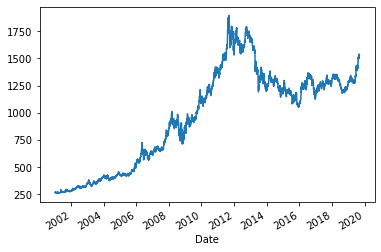

In [32]:
df['USD (PM)'].plot()

# Train Test Split Predictions

Training Period: 2001-2018
Testing Period: 2019

In [34]:
# Create a train/test split for the data using 2001-2018 for training and 2019 for testing
train = df['2001':'2018']
test = df['2019']

In [35]:
# Create train and test sets for dependent and independent variables
X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]
X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

In [36]:
# Create and fit model to the data, make predictions
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [38]:
# Construct a dataframe using just the "y" training data:
out_of_sample_results = y_test.to_frame()

# Add a column of "out-of-sample" predictions to that dataframe:  
out_of_sample_results["Out-of-Sample Predictions"] = model.predict(X_test)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

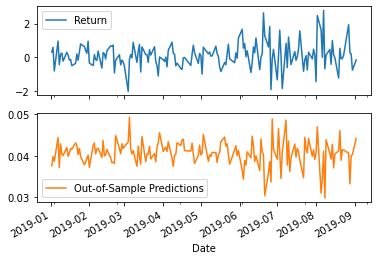

In [39]:
# Plot the out-of-sample results for 2019
out_of_sample_results.plot(subplots=True)

In [40]:
# Calculate out-of-sample mean_squared_error (for comparison to out-of-sample)
out_of_sample_mse = mean_squared_error(
    out_of_sample_results["Return"],
    out_of_sample_results["Out-of-Sample Predictions"]
)

# Calculate out-of-sample root mean_squared_error (for comparison to out-of-sample)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
r2 = r2_score(out_of_sample_results["Return"], out_of_sample_results["Out-of-Sample Predictions"])
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")
print(f"Out-of-Sample r2: {r2}")

Out-of-sample Root Mean Squared Error (RMSE): 0.7386325510756194
Out-of-Sample r2: -0.008166729061278355


---

# Rolling Out-of-Sample Predictions

In [43]:
# Split the index into weekly periods
weeks = df.index.to_period("w").unique()
print(weeks[0])

2001-01-08/2001-01-14


In [44]:
# Declare the training window of 12 weeks
# Define the imeframe of rolling windows
training_window = 12
timeframe = len(weeks) - training_window - 1
print(timeframe)

961


In [45]:
# Construct empty placeholder dataframes.
# (During each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_actuals = pd.DataFrame(columns=["Actual Returns"])

In [46]:
# During rolling iteration, split into train and test sets.
# Use linear regression to make out-of-sample predictions.
# Append the results to external dataframes.
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window+i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window + i + 1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = df.loc[start_of_training_period:end_of_training_period]
    test = df.loc[start_of_test_week:end_of_test_week]
    
    # Create new dataframes:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Create a temporary dataframe to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    
    # Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    

In [47]:
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

,Actual Returns,Out-of-Sample Predictions
2001-04-09,0.077280,0.017081
2001-04-10,-0.907336,-0.021909
2001-04-11,0.409117,-0.219867
2001-04-12,0.601475,0.044807
2001-04-17,0.501446,0.096709


In [48]:
# 2019 Data
results_2019 = Results.loc['2019':]
results_2019

,Actual Returns,Out-of-Sample Predictions
2019-01-02,0.304926,0.174306
2019-01-03,0.588510,0.135377
2019-01-04,-0.817544,0.155000
2019-01-07,0.961013,0.026778
2019-01-08,-0.444978,0.173611
...,...,...
2019-08-27,1.938423,0.267097
2019-08-28,0.273982,0.082971
2019-08-29,0.198419,0.251182
2019-08-30,-0.766134,0.258819


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

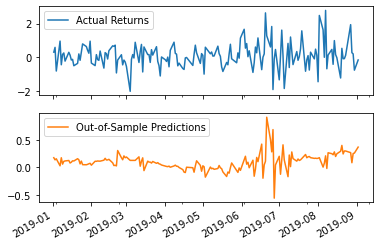

In [49]:
# Plot the results
results_2019.plot(subplots=True)

In [50]:
# Out-of-sample metrics
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(
    results_2019["Actual Returns"],
    results_2019["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rolling_rmse = np.sqrt(mse)
rolling_r2 = r2_score(results_2019["Actual Returns"], results_2019["Out-of-Sample Predictions"])
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")
print(f"Rolling Out-of-Sample r2: {rolling_r2}")

Rolling Out-of-Sample Root Mean Squared Error (RMSE): 0.7513046345767126
Rolling Out-of-Sample r2: -0.04305596516272914


# Final Model Comparison

In [51]:
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}\n")

print(f"Out-of-Sample r2: {r2}")
print(f"Rolling Out-of-Sample r2: {rolling_r2}")

Out-of-sample Root Mean Squared Error (RMSE): 0.7386325510756194
Rolling Out-of-Sample Root Mean Squared Error (RMSE): 0.7513046345767126

Out-of-Sample r2: -0.008166729061278355
Rolling Out-of-Sample r2: -0.04305596516272914


Comparing the two RMSE's, the RMSE from the single training window is 0.73, whereas it is 0.75 from the rolling-out-of-sample model.

* The rolling-out-of sample approach is an approach more akin to real life (you likely re-estimate your model when new data becomes available)
* In addition to being more realistic, the rolling-out of sample approach is also more rigorous, as you are testing your model many more times across different time periods
* Therefore, we expect a slightly higher out-of-sample RMSE, which is what we see.
* The fact that the two are close to each other in value though does suggest that our model is reasonably stable.